In [29]:
import numpy as np
import neptune
import imageio
import scipy as scipy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import skimage as skim

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from src.data_generator import ShiftedDataBatcher
from src.data_loader import _shift_image
from src.test_models.drduplex import DRDuplex
from src.utils import save_model, save_model_and_weights, save_weights

In [3]:
# exp_date = '2019-09-28'
exp_date = '2019-09-25'
proj_root = '/home/elijahc/projects/vae'
models_root = os.path.join(proj_root,'models',exp_date)

In [4]:
PROPS = {
    'dataset':'fashion_mnist',
    'encoder_arch': 'dense',
    'generator_arch': 'resnet',
    'augmentation': 'dynamic',
}
PARAMS = {}

train_conf = {
    'n_epochs': 54000,
    'batch_sz':512,
}

data_conf = {
    'bg': 'natural',
    'im_translation':0.75,
    'bg_contrast': 0.3,
}

model_conf = {
    'xent_weight': 15,
    'recon_weight': 1,
    'y_dim':35,
    'z_dim':35,
}

for conf in [train_conf,data_conf,model_conf]:
    PARAMS.update(conf)

In [5]:
DB = ShiftedDataBatcher(PROPS['dataset'],translation=PARAMS['im_translation'],bg=PARAMS['bg'],
                        blend=None,
#                         blend='difference',
                        batch_size=PARAMS['batch_sz'],
                       )

(512, 56, 56, 1) (512, 10)
-1.0 1.0
-1.0 1.0


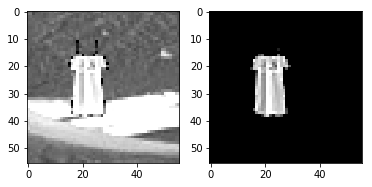

In [8]:
gen = DB.gen_train_batches(2,bg=PARAMS['bg'],bg_contrast=PARAMS['bg_contrast'])
x,xbg,y = next(gen)
print(x.shape,y.shape)

fig,axs = plt.subplots(1,2)
print(x[5].min(),x[5].max())
print(xbg[5].min(),xbg[5].max())

axs[0].imshow(x[5].reshape(56,56),cmap='gray')
axs[1].imshow(xbg[5].reshape(56,56),cmap='gray')
# plt.colorbar()

In [9]:
neptune.init('elijahc/DuplexAE')
src_files = [
    './src/data_generator.py',
    './src/data_loader.py',
    './src/test_models/drduplex.py',
    './src/test_models/partials.py',
    './src/test_models/encoders.py',
]
exp = neptune.create_experiment(name='natural_w_recon',properties=PROPS,params=PARAMS,upload_source_files=src_files)
exp_dir = os.path.join('models',exp_date,exp.id) 

os.mkdir(os.path.join(proj_root,exp_dir))
os.mkdir(os.path.join(proj_root,exp_dir,'recons'))
os.mkdir(os.path.join(proj_root,exp_dir,'test_ims'))

exp.set_property('dir',exp_dir)

https://ui.neptune.ml/elijahc/DuplexAE/e/DPX-27


Experiment(DPX-27)

In [10]:
w_xent = PARAMS['xent_weight']
w_recon = PARAMS['recon_weight']

In [11]:
mod = DRDuplex(img_shape=(56,56,1),y_dim=PARAMS['y_dim'],z_dim=PARAMS['z_dim'],
               num_classes=DB.num_classes,
               recon=w_recon,
               xent=w_xent,n_residual_blocks=4,
#                kernel_regularization=1e-5,
              )

In [15]:
mod_dir = os.path.join(proj_root,exp_dir)
mod_dir

'/home/elijahc/projects/vae/models/2019-09-25/DPX-27'

In [17]:
save_model(mod.combined,mod_dir)

In [18]:
mod.combined.metrics_names

['loss',
 'Generator_loss',
 'Classifier_loss',
 'Generator_mean_squared_error',
 'Classifier_acc']

In [ ]:
# val_pct = 0.05
# val_idxs = np.random.choice(np.arange(10000),int(val_pct*60000),replace=False)
# validation_set = (DB.x_te[val_idxs],
#                   {'Classifier':DB.y_test_oh[val_idxs],
#                    'Generator':DB.fg_test[val_idxs]}
#                  )

In [19]:
i = 0
epoch_sz = int(DB.num_train/512)
pan_ims = []
pan_y = []

# hist_labels = mod.combined.metrics_names
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

train_hist = []
test_hist = []

# val_X,val_X_fg,val_y = DB.gen_batch(DB.x_te,DB.y_test_oh,batch_size=1000,bg='natural')


In [20]:
num_pan = 3
test_generator = DB.gen_test_batches(4, batch_size=PARAMS['batch_sz'], bg=PARAMS['bg'])
not_unique = True
while not_unique:
    pan_idx = np.random.choice(np.arange(len(DB.x_te)),size=num_pan,replace=False)
    if len(np.unique(DB.y_test[pan_idx])) == num_pan:
        not_unique = False
    
px_ = DB.x_te[pan_idx]
print(px_.shape)
tX, tX_fg,ty = next(test_generator)

(3, 28, 28)


In [21]:
x_span = DB.gen_pan_deltas(step=2)
pX = np.stack([np.expand_dims(_shift_image(X=px_,dx=dx,dy=dy),-1) for dx,dy in x_span])

scaler = MinMaxScaler(feature_range=(-1,1))
n,r,x,y,c = pX.shape

pX = scaler.fit_transform(pX.reshape(n,x*y*c*r)).reshape(n,r,x,y,c)

In [38]:
npX = skim.util.random_noise(pX,mode='gaussian',var=0.1)


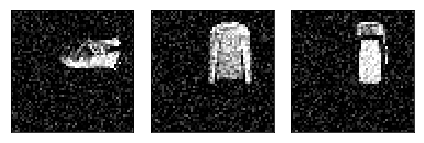

In [39]:
fig,axs = plt.subplots(1,num_pan)
for i,ax in enumerate(axs.ravel()):
    ax.imshow(npX[29,i].reshape(56,56),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.tight_layout()

In [ ]:
# import numpy as np
# nj = 25
# fig,axs = plt.subplots(1,nj,figsize=(2*nj,2))

# for i in np.arange(nj):
#     axs[i].imshow(pX[i+15].reshape(56,56))

In [24]:
def flush_pan(pan_ims):
    min_max = lambda xp: np.clip((xp+1)/2,0,1)
    for idx,inp,G in pan_ims:
        idx = str(idx).zfill(3)
        
#         inp_fn = 'input_{}.png'.format(idx)
#         inp_fp = os.path.join(proj_root,exp_dir,'test_ims',inp_fn)
        
        G_fn = 'G_{}.png'.format(idx)
        G_fp = os.path.join(proj_root,exp_dir,'recons',G_fn)
    
        fig,axs = plt.subplots(2,num_pan)
        for k in np.arange(num_pan):
            axs[0,k].imshow(inp[k],cmap='gray')
            axs[1,k].imshow(G[k],cmap='gray')

        for ax in axs.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()     
        
        fig.savefig(G_fp)
        plt.close(fig)

In [25]:
recon_dir = os.path.join(proj_root,exp_dir,'recons')
input_dir = os.path.join(proj_root,exp_dir,'test_ims')

In [26]:
def make_gif(recon_dir,input_dir,fps=8,loop=0):
    G_ims = []
    for G in sorted(os.listdir(recon_dir)):
        if G.endswith('.png'):
            G_fp = os.path.join(recon_dir, G)
            G_ims.append(imageio.imread(G_fp))
        
#     imageio.mimsave(os.path.join(proj_root,exp_dir,'inputs_video.gif'), input_ims,fps=fps,loop=loop)
    imageio.mimsave(os.path.join(proj_root,exp_dir,'G_video.gif'), G_ims, fps=fps,loop=loop)

In [ ]:
for X,X_fg,y in DB.gen_train_batches(PARAMS['n_epochs'],bg=PARAMS['bg']):
    y = {'Classifier':y,
         'Generator':X_fg,
        }
    r = mod.combined.train_on_batch(X,y)
    r = {k:v for k,v in zip(hist_labels,r)}

#     metrics = {k:v for k,v in zip(met_names,met_vals)}
    if i % epoch_sz == 0 and i > 0:
        r_te = mod.combined.test_on_batch(tX,{'Classifier':ty,
                                              'Generator':tX_fg
                                             })
        r_te = {k:v for k,v in zip(hist_labels,r_te)}
        exp.log_metric('batch',i)
        for metric in hist_labels:
            exp.log_metric(metric,r[metric])
            exp.log_metric('val_{}'.format(metric),r_te[metric])

        r['batch']=i
        r_te['batch']=i

#         r['result_type'] = 'train'
#         r_te['result_type'] = 'valid'

#         train_hist.append(r)
#         train_hist.append(r_te)

        p_loss = "{:5d} (train/val) G/C_loss[{:2.2f}/{:.2f},   {:2.2f}/{:.2f}]".format(i,r['G_loss'],r['C_loss'],r_te['G_loss'],r_te['C_loss'])
#         p_loss = "{:5d} (train/val loss:[{:2.2f}, {:2.2f}])".format(i,r['loss'],r_te['loss'])
        p_acc = "[acc: {:2.2%},   val_acc: {:2.2%}]".format(r['acc'],r_te['acc'])
        print(p_loss,' ',p_acc)
        
        pidx = int(i/epoch_sz)%len(pX)
        im = skim.util.random_noise(pX[pidx],mode='gaussian',var=0.1)
        p_recon,p_class = mod.combined.predict_on_batch(im)
        
        pan_im = (int(i/epoch_sz), np.squeeze(im), np.squeeze(p_recon))
        pan_ims.append(pan_im)
        pan_y.append(p_class)
        
        if i>0 and len(pan_ims)>int(len(pX)/3):
            print('writing_image_buffer...')
            flush_pan(pan_ims)
            pan_ims = []
                
            print('recompiling video...')
            make_gif(recon_dir,input_dir)
                        
    i+=1

  117 (train/val) G/C_loss[1055.22/2.30,   1080.69/2.32]   [acc: 12.30%,   val_acc: 11.91%]
  234 (train/val) G/C_loss[571.90/2.25,   553.98/2.28]   [acc: 15.82%,   val_acc: 15.04%]
  351 (train/val) G/C_loss[424.75/2.25,   411.32/2.26]   [acc: 14.65%,   val_acc: 16.21%]
  468 (train/val) G/C_loss[358.97/2.23,   361.11/2.25]   [acc: 17.58%,   val_acc: 15.04%]
  585 (train/val) G/C_loss[341.18/2.22,   335.01/2.24]   [acc: 19.73%,   val_acc: 15.62%]
  702 (train/val) G/C_loss[325.95/2.20,   316.26/2.21]   [acc: 18.36%,   val_acc: 17.38%]
  819 (train/val) G/C_loss[306.87/2.16,   305.22/2.18]   [acc: 20.70%,   val_acc: 19.92%]
  936 (train/val) G/C_loss[287.02/2.14,   298.12/2.16]   [acc: 19.14%,   val_acc: 19.34%]
 1053 (train/val) G/C_loss[301.10/2.13,   295.09/2.13]   [acc: 23.05%,   val_acc: 20.70%]
 1170 (train/val) G/C_loss[307.97/2.10,   291.00/2.10]   [acc: 21.68%,   val_acc: 23.05%]
 1287 (train/val) G/C_loss[296.94/2.04,   286.71/2.08]   [acc: 27.73%,   val_acc: 24.41%]
 1404 (t

In [41]:
flush_pan(pan_ims)
pan_ims = []
make_gif(recon_dir,input_dir,)

In [42]:
exp.stop()

In [43]:
mod_dir = os.path.join(proj_root,exp_dir)
mod_dir

'/home/elijahc/projects/vae/models/2019-09-25/DPX-27'

In [44]:
hist_tr = pd.DataFrame.from_records(train_hist)

In [45]:
# sns.set_context('talk')
# fig,axs = plt.subplots(1,4,figsize=(4*4,1*4),sharex=True)
# for ax,metric in zip(axs.ravel(),['loss','G_loss','C_loss','acc']):
#     sns.lineplot(x='batch',y=metric, hue='result_type',data=hist_tr,ax=ax)

In [46]:
print(mod_dir)
hist_tr.to_csv(os.path.join(mod_dir,'training_hist.csv'))

/home/elijahc/projects/vae/models/2019-09-25/DPX-27


In [ ]:
model_json = mod.combined.to_json()
with open(os.path.join(mod_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)
    
exp.send_artifact(os.path.join(mod_dir,'model.json'))

In [47]:
mod.combined.save_weights(os.path.join(mod_dir,'weights.h5'))

In [74]:
teX,teX_fg,te_y = next(test_generator)

In [75]:
res = mod.combined.evaluate(teX,{'Classifier':te_y,'Generator':teX_fg},batch_size=PARAMS['batch_sz'])


512/512 [==============================] - 0s 135us/step


In [76]:
res

[165.2099609375,
 146.4774627685547,
 1.246190071105957,
 0.0467083714902401,
 0.552734375]

In [73]:
nteX = skim.util.random_noise(teX,mode='gaussian',var=0.2)
nout = mod.combined.predict_on_batch(nteX)

AttributeError: 'Model' object has no attribute 'evaluate_on_batch'

In [78]:
out = mod.combined.predict_on_batch(teX)
x_recon,y = out
n_recon,ny = nout

In [87]:
choices = np.random.choice(np.arange(512),size=5,replace=False)

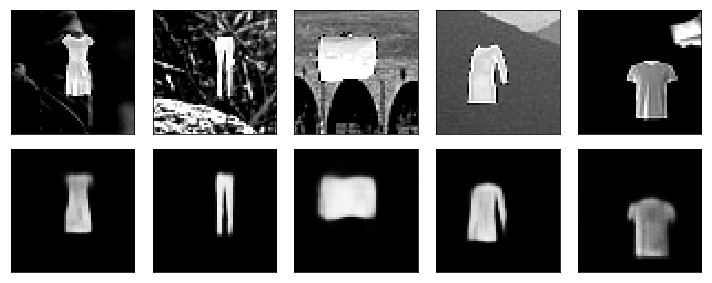

In [88]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(teX[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    axs[1].imshow(x_recon[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()

In [89]:
fig.savefig(os.path.join(mod_dir,'inp_output_pairs.png'),dpi=150)

In [90]:
exp.send_artifact(os.path.join(mod_dir,'inp_output_pairs.png'))

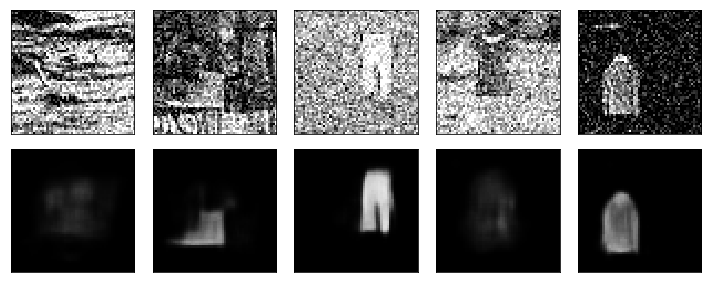

In [72]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(nteX[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    axs[1].imshow(n_recon[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()